In [130]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, recall_score, roc_curve, precision_score, f1_score

In [131]:
consdf = pd.read_parquet('/uss/hdsi-prismdata/q2-ucsd-consDF.pqt')
consdf

,prism_consumer_id,evaluation_date,credit_score,DQ_TARGET
0,0,2021-09-01,726.0,0.0
1,1,2021-07-01,626.0,0.0
2,2,2021-05-01,680.0,0.0
3,3,2021-03-01,734.0,0.0
4,4,2021-10-01,676.0,0.0
...,...,...,...,...
14995,14995,2022-03-08,655.0,NaN
14996,14996,2022-01-15,625.0,NaN
14997,14997,2022-01-31,688.0,NaN
14998,14998,2022-03-08,722.0,NaN


In [132]:
acctdf = pd.read_parquet('/uss/hdsi-prismdata/q2-ucsd-acctDF.pqt')
acctdf

,prism_consumer_id,prism_account_id,account_type,balance_date,balance
0,3023,0,SAVINGS,2021-08-31,90.57
1,3023,1,CHECKING,2021-08-31,225.95
2,4416,2,SAVINGS,2022-03-31,15157.17
3,4416,3,CHECKING,2022-03-31,66.42
4,4227,4,CHECKING,2021-07-31,7042.90
...,...,...,...,...,...
24461,11500,24461,CHECKING,2022-03-27,732.75
24462,11615,24462,SAVINGS,2022-03-30,5.00
24463,11615,24463,CHECKING,2022-03-30,1956.46
24464,12210,24464,CHECKING,2022-03-28,2701.51


In [133]:
trxndf = pd.read_parquet('/uss/hdsi-prismdata/q2-ucsd-trxnDF.pqt')
trxndf

,prism_consumer_id,prism_transaction_id,category,amount,credit_or_debit,posted_date
0,3023,0,4,0.05,CREDIT,2021-04-16
1,3023,1,12,481.56,CREDIT,2021-04-30
2,3023,2,4,0.05,CREDIT,2021-05-16
3,3023,3,4,0.07,CREDIT,2021-06-16
4,3023,4,4,0.06,CREDIT,2021-07-16
...,...,...,...,...,...,...
6407316,10533,6405304,31,4.96,DEBIT,2022-03-11
6407317,10533,6405305,12,63.48,DEBIT,2022-03-30
6407318,10533,6405306,12,53.99,DEBIT,2022-03-30
6407319,10533,6405307,12,175.98,DEBIT,2022-03-31


## week 1 - feature importance

looking at how often balances get below $0 because it directly measures behavior and failures states 

In [134]:
acctdf['balance_date'] = pd.to_datetime(acctdf['balance_date'])


In [135]:
df = acctdf.merge(consdf, on='prism_consumer_id')
df

,prism_consumer_id,prism_account_id,account_type,balance_date,balance,evaluation_date,credit_score,DQ_TARGET
0,3023,0,SAVINGS,2021-08-31,90.57,2021-09-01,699.0,0.0
1,3023,1,CHECKING,2021-08-31,225.95,2021-09-01,699.0,0.0
2,4416,2,SAVINGS,2022-03-31,15157.17,2021-04-01,724.0,NaN
3,4416,3,CHECKING,2022-03-31,66.42,2021-04-01,724.0,NaN
4,4227,4,CHECKING,2021-07-31,7042.90,2021-08-01,707.0,NaN
...,...,...,...,...,...,...,...,...
24461,11500,24461,CHECKING,2022-03-27,732.75,2022-03-27,686.0,0.0
24462,11615,24462,SAVINGS,2022-03-30,5.00,2022-03-30,664.0,0.0
24463,11615,24463,CHECKING,2022-03-30,1956.46,2022-03-30,664.0,0.0
24464,12210,24464,CHECKING,2022-03-28,2701.51,2022-03-28,660.0,0.0


In [136]:
df['DQ_TARGET'].value_counts()

DQ_TARGET
0.0    17979
1.0     1508
Name: count, dtype: int64

In [137]:
DQ_0 = df[df['DQ_TARGET'] == 0.0]
DQ_0

,prism_consumer_id,prism_account_id,account_type,balance_date,balance,evaluation_date,credit_score,DQ_TARGET
0,3023,0,SAVINGS,2021-08-31,90.57,2021-09-01,699.0,0.0
1,3023,1,CHECKING,2021-08-31,225.95,2021-09-01,699.0,0.0
5,3920,5,SAVINGS,2021-10-31,0.26,2021-11-01,736.0,0.0
6,3920,6,CHECKING,2021-10-31,4.42,2021-11-01,736.0,0.0
7,3920,7,CHECKING,2021-10-31,1.05,2021-11-01,736.0,0.0
...,...,...,...,...,...,...,...,...
24461,11500,24461,CHECKING,2022-03-27,732.75,2022-03-27,686.0,0.0
24462,11615,24462,SAVINGS,2022-03-30,5.00,2022-03-30,664.0,0.0
24463,11615,24463,CHECKING,2022-03-30,1956.46,2022-03-30,664.0,0.0
24464,12210,24464,CHECKING,2022-03-28,2701.51,2022-03-28,660.0,0.0


In [138]:
DQ_1 = df[df['DQ_TARGET'] == 1.0 ]
DQ_1

,prism_consumer_id,prism_account_id,account_type,balance_date,balance,evaluation_date,credit_score,DQ_TARGET
29,196,29,SAVINGS,2021-08-27,18.86,2021-09-01,573.0,1.0
30,196,30,CHECKING,2021-11-30,1282.98,2021-09-01,573.0,1.0
55,3806,55,SAVINGS,2021-09-30,0.00,2021-10-01,680.0,1.0
56,3806,56,CHECKING,2021-09-30,4523.18,2021-10-01,680.0,1.0
239,2162,239,SAVINGS,2021-02-28,193.25,2021-03-01,665.0,1.0
...,...,...,...,...,...,...,...,...
24230,12880,24230,SAVINGS,2022-03-27,8044.50,2022-03-27,664.0,1.0
24233,12880,24233,CHECKING,2022-03-27,491.59,2022-03-27,664.0,1.0
24399,12162,24399,CHECKING,2021-12-09,154.58,2021-12-09,654.0,1.0
24424,12162,24424,CHECKING,2021-12-09,126.27,2021-12-09,654.0,1.0


In [139]:
DQ_1['credit_score'].mean()

593.8415119363395

In [140]:
df['credit_score'].mean()

665.3855963377749

In [141]:
df['balance'].mean()

4296.199248753373

In [142]:
DQ_1['balance'].mean()

1284.024675066313

In [143]:
df[df['balance'] < 0]

,prism_consumer_id,prism_account_id,account_type,balance_date,balance,evaluation_date,credit_score,DQ_TARGET
82,2246,82,CHECKING,2021-04-30,-168.90,2021-05-01,703.0,0.0
206,2751,206,CHECKING,2022-03-30,-474.41,2022-04-01,677.0,0.0
506,2242,506,CHECKING,2022-03-31,-49.52,2022-02-01,662.0,0.0
616,3280,616,CHECKING,2021-11-30,-7.23,2021-12-01,680.0,0.0
904,1056,904,CHECKING,2021-03-31,-313.61,2021-04-01,655.0,0.0
...,...,...,...,...,...,...,...,...
24239,12997,24239,CREDIT CARD,2021-12-14,-25.00,2021-12-14,695.0,0.0
24279,13976,24279,CREDIT CARD,2022-02-15,-1025.27,2022-02-15,806.0,0.0
24296,11678,24296,CHECKING,2021-12-19,-145.00,2021-12-19,657.0,0.0
24357,10353,24357,SAVINGS,2021-12-16,-10.00,2021-12-16,685.0,0.0


### bottom 10th percentile

creating a feature using the bottom 10th percentile of their balances to get a sense of how low their balances get

In [144]:
balance_p10 = (
    df.groupby('prism_consumer_id')['balance']
      .quantile(0.10)
      .reset_index()
      .rename(columns={'balance': 'balance_p10'})
)
balance_p10

,prism_consumer_id,balance_p10
0,0,52.597
1,1,403.234
2,10,83.616
3,100,907.467
4,1000,9.541
...,...,...
13004,9995,0.000
13005,9996,252.670
13006,9997,611.280
13007,9998,-862.990


In [145]:
dq_labels = (df[['prism_consumer_id', 'DQ_TARGET']].drop_duplicates())

In [146]:
model_df = balance_p10.merge(dq_labels, on='prism_consumer_id', how='inner')
model_df = model_df.dropna(subset=['DQ_TARGET'])
model_df

,prism_consumer_id,balance_p10,DQ_TARGET
0,0,52.597,0.0
1,1,403.234,0.0
2,10,83.616,0.0
3,100,907.467,0.0
4,1000,9.541,0.0
...,...,...,...
12956,995,22142.967,0.0
12966,996,0.000,0.0
12977,997,11732.731,0.0
12987,998,1340.621,0.0


In [147]:
# model_df[model_df['balance_p10'] < 0]

- logistic regression maps features to a probability of being 1
- ROC-AUC measures how well those probabilities separate 0s from 1s

here, a low balance indicates a higher risk so we need to take the negative because logistic regression assumes that higher values of X increase probability of positive class but it's inverted
- higher X --> higher predicted probability of DQ=1

In [154]:
X = -model_df[['balance_p10']]
y = model_df['DQ_TARGET']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

model = LogisticRegression()
model.fit(X_train, y_train)

y_prob = model.predict_proba(X_test)[:, 1]

# lowered threshold bc of class imbalance
y_pred = (y_prob >= 0.1).astype(int)

auc = roc_auc_score(y_test, y_prob)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"ROC-AUC: {auc:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall (DQ=1): {recall:.3f}")
print(f"F1-score: {f1:.3f}")


ROC-AUC: 0.703
Precision: 0.132
Recall (DQ=1): 0.796
F1-score: 0.227


**roc-auc**:  if you take one person who became delinquent and one who didn’t, the model will correctly rank the delinquent person as riskier about 7 out of 10 times

**precision**: of all the accounts that the model predicted as DQ=1, only 13% were actually delinquent

**recall**: of all the actual delinquent accounts, the model correctly identified about 80%

**f1-score**: while the model catches most positives, many predicted positives are actually false

bad because catching most DQ=1 accounts at the expense of predicting a lot of false positives

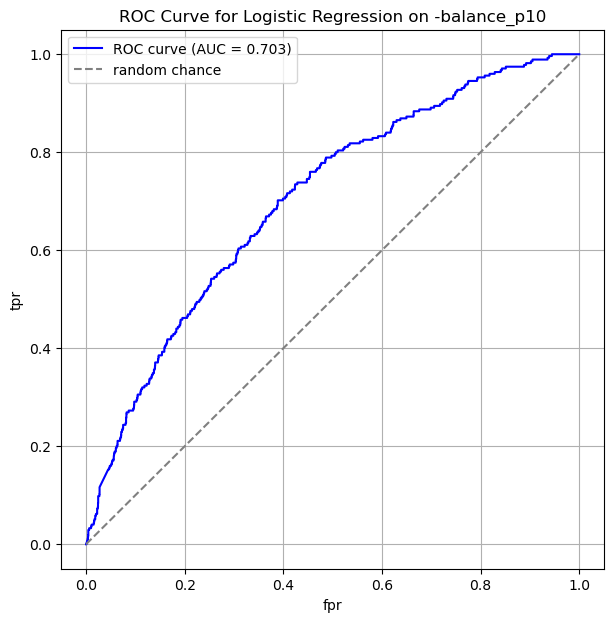

In [155]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(7,7))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {auc:.3f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='random chance')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC Curve for Logistic Regression on -balance_p10')
plt.legend()
plt.grid(True)
plt.show()

In [156]:
y_prob.min(), y_prob.max()


(2.9110426277401513e-46, 0.42354919347848785)

even the riskiest person I can find only has about a 23% chance of being delinquent
this means that: 
1. deliquency is rare (1508 versus 17979)
2. only using one feature (if we had more features it would be more accurate at correctly predicitng)
3. this model is better at ranking than classification (yes/no decisions)

but roc-auc is still helpful because riskier people still get higher scores than safer people

In [157]:
threshold = np.percentile(y_prob, 90)  # top 10%
y_pred_top10 = (y_prob >= threshold).astype(int)

recall_top10 = recall_score(y_test, y_pred_top10)
print(f"Recall in top 10% risk: {recall_top10:.3f}")


Recall in top 10% risk: 0.269


if we take the 10% riskiest users according to the model, we correctly catch 31.3% of all bad users, which is about 3x better than random even though there is heavy class imbalance

**literally just average balance**

In [158]:
balance_mean = (
    df.groupby('prism_consumer_id')['balance']
      .mean()
      .reset_index()
      .rename(columns={'balance': 'balance_mean'})
)

mean_df = balance_mean.merge(dq_labels, on='prism_consumer_id')

mean_df = mean_df.dropna(subset=['DQ_TARGET'])

X = -mean_df[['balance_mean']]
y = mean_df['DQ_TARGET']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

model.fit(X_train, y_train)
y_prob = model.predict_proba(X_test)[:, 1]

auc = roc_auc_score(y_test, y_prob)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"ROC-AUC: {auc:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall (DQ=1): {recall:.3f}")
print(f"F1-score: {f1:.3f}")



ROC-AUC: 0.717
Precision: 0.132
Recall (DQ=1): 0.796
F1-score: 0.227


**roc-auc**: if you take one person who became delinquent and one who didn’t, the model will correctly rank the delinquent person as riskier about 7 out of 10 times (0.717)

**precision**: of all the accounts that the model predicted as DQ=1, only 13% were actually delinquent (0.132)

**recall**: of all the actual delinquent accounts, the model correctly identified about 80% (0.796)

**f1-score**: while the model catches most positives, many predicted positives are actually false (0.227)

using mean balance as a feature is good at catching most DQ=1 accounts, but it also predicts a lot of false positives

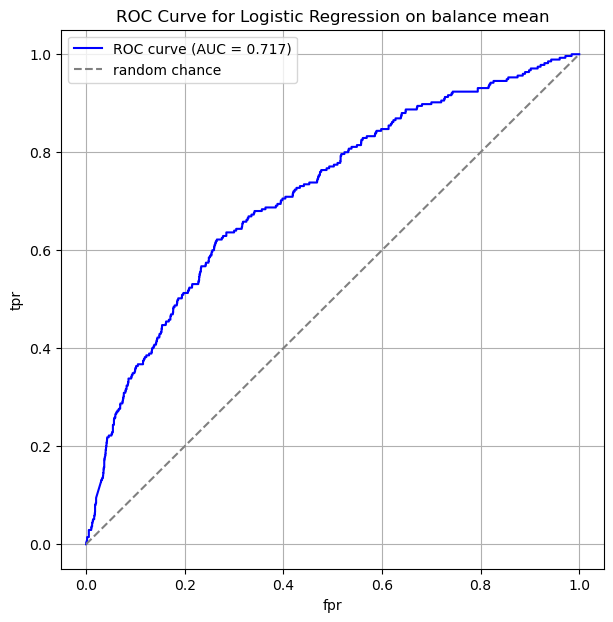

In [159]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(7,7))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {auc:.3f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='random chance')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC Curve for Logistic Regression on balance mean')
plt.legend()
plt.grid(True)
plt.show()

### new flow = total credits - total debits

or **average net flow**=net flow / number of months over a periiod

In [160]:
cons_acct = pd.merge(consdf, acctdf, on='prism_consumer_id', how='left')
full_df = pd.merge(trxndf, cons_acct, on='prism_consumer_id', how='left')
print(full_df.shape)
full_df.head()


(12828110, 13)


,prism_consumer_id,prism_transaction_id,category,amount,credit_or_debit,posted_date,evaluation_date,credit_score,DQ_TARGET,prism_account_id,account_type,balance_date,balance
0,3023,0,4,0.05,CREDIT,2021-04-16,2021-09-01,699.0,0.0,0,SAVINGS,2021-08-31,90.57
1,3023,0,4,0.05,CREDIT,2021-04-16,2021-09-01,699.0,0.0,1,CHECKING,2021-08-31,225.95
2,3023,1,12,481.56,CREDIT,2021-04-30,2021-09-01,699.0,0.0,0,SAVINGS,2021-08-31,90.57
3,3023,1,12,481.56,CREDIT,2021-04-30,2021-09-01,699.0,0.0,1,CHECKING,2021-08-31,225.95
4,3023,2,4,0.05,CREDIT,2021-05-16,2021-09-01,699.0,0.0,0,SAVINGS,2021-08-31,90.57


In [161]:
full_df['posted_date'] = pd.to_datetime(full_df['posted_date'])

net_flow_df = full_df.groupby('prism_consumer_id').apply(
    lambda x: pd.Series({
        'total_credit': x.loc[x['credit_or_debit'] == 'CREDIT', 'amount'].sum(),
        'total_debit': x.loc[x['credit_or_debit'] == 'DEBIT', 'amount'].sum(),
        'first_date': x['posted_date'].min(),
        'last_date': x['posted_date'].max()
    })
).reset_index()

net_flow_df['net_flow'] = net_flow_df['total_credit'] - net_flow_df['total_debit']
net_flow_df['months_active'] = ((net_flow_df['last_date'] - net_flow_df['first_date']).dt.days / 30).apply(lambda x: max(x, 1))
net_flow_df['avg_net_flow'] = net_flow_df['net_flow'] / net_flow_df['months_active']

full_df = pd.merge(full_df, net_flow_df[['prism_consumer_id', 'net_flow', 'avg_net_flow']], 
                   on='prism_consumer_id', how='left')

full_df = full_df.dropna(subset=['DQ_TARGET'])


full_df[['prism_consumer_id', 'net_flow', 'avg_net_flow', 'DQ_TARGET']].drop_duplicates().head()


/tmp/ipykernel_240/3257707724.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  net_flow_df = full_df.groupby('prism_consumer_id').apply(


,prism_consumer_id,net_flow,avg_net_flow,DQ_TARGET
0,3023,1320.08,220.013333,0.0
1008,3920,-592.53,-99.306704,0.0
1624,318,-67946.32,-11324.386667,0.0
2726,3856,-676.06,-131.700000,0.0
2758,341,293.88,48.980000,0.0


**net flows**

In [162]:
X = full_df[['prism_consumer_id', 'net_flow']].drop_duplicates()[['net_flow']]
y = full_df[['prism_consumer_id', 'DQ_TARGET']].drop_duplicates()['DQ_TARGET']  # target column
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [163]:
net_flow_df = full_df[['prism_consumer_id', 'net_flow']].drop_duplicates()
dq_df = full_df[['prism_consumer_id', 'DQ_TARGET']].drop_duplicates()
model_df = net_flow_df.merge(dq_df, on='prism_consumer_id', how='inner')

X = model_df[['net_flow']]
y = model_df['DQ_TARGET']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred_proba = model.predict_proba(X_test)[:, 1]

In [164]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"roc-auc: {roc_auc:.3f}")

roc-auc: 0.566


In [165]:
# precision, recall, F1 at a lowered threshold because all were 0 at 0.5, 0.2
y_pred = (y_pred_proba >= 0.1).astype(int)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-score: {f1:.3f}")

Precision: 0.095
Recall: 0.007
F1-score: 0.013


**roc-auc**: if you take one person who became delinquent and one who didn’t, the model will correctly rank the delinquent person as riskier about 57 out of 100 times (0.566)

**precision**: of all the accounts that the model predicted as DQ=1, only 9.5% were actually delinquent (0.095)

**recall**: of all the actual delinquent accounts, the model correctly identified less than 1% (0.007)

**f1-score**: while the model catches very few positives, most predicted positives are false (0.013)

using net_flow as a feature is very weak at predicting delinquency, with almost no ability to identify actual DQ=1 accounts

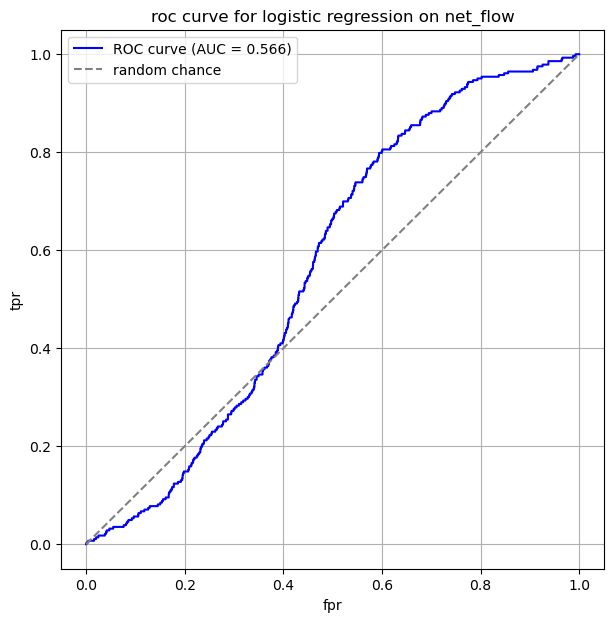

In [166]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)


plt.figure(figsize=(7,7))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='random chance')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('roc curve for logistic regression on net_flow')
plt.legend()
plt.grid(True)
plt.show()

histogram + KDE plot

<Axes: xlabel='net_flow', ylabel='Count'>

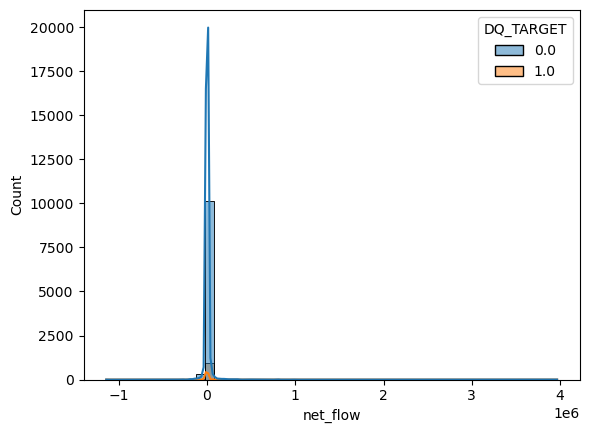

In [167]:
sns.histplot(data=model_df, x='net_flow', hue='DQ_TARGET', bins=50, kde=True)


**average net flows**

In [168]:
X = full_df[['prism_consumer_id', 'avg_net_flow']].drop_duplicates()[['avg_net_flow']]
y = full_df[['prism_consumer_id', 'DQ_TARGET']].drop_duplicates()['DQ_TARGET']  # target column
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [169]:
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred_proba = model.predict_proba(X_test)[:, 1]  # probability of positive class


In [170]:
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("ROC-AUC for avg net flow:", roc_auc)


ROC-AUC for avg net flow: 0.5602783983806133


In [172]:
y_pred = (y_pred_proba >= 0.1).astype(int)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-score: {f1:.3f}")

Precision: 0.091
Recall: 0.007
F1-score: 0.013


**roc-auc**: if you take one person who became delinquent and one who didn’t, the model will correctly rank the delinquent person as riskier about 56 out of 100 times (0.560)

**precision**: of all the accounts that the model predicted as DQ=1, only 9.1% were actually delinquent (0.091)

**recall**: of all the actual delinquent accounts, the model correctly identified less than 1% (0.007)

**f1-score**: while the model catches very few positives, most predicted positives are false (0.013)

using avg_net_flow as a feature is very weak at predicting delinquency, with almost no ability to identify actual DQ=1 accounts.

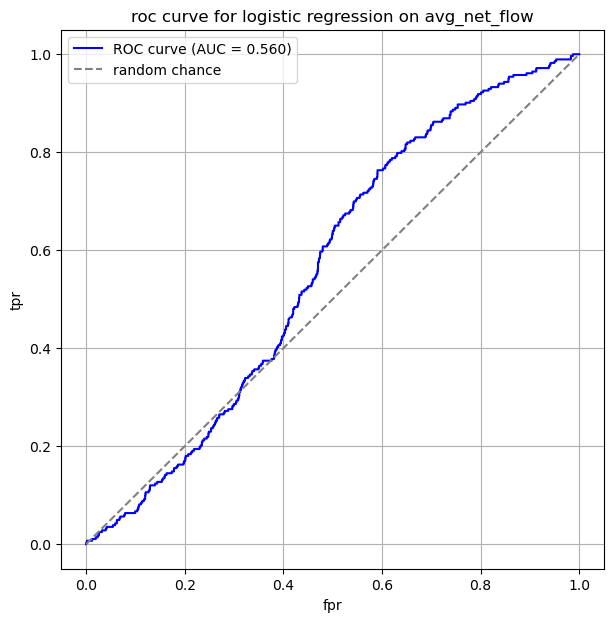

In [171]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(7,7))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='random chance')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('roc curve for logistic regression on avg_net_flow')
plt.legend()
plt.grid(True)
plt.show()